In [3]:
%%capture
!pip install pytorch-lightning datasets transformers albumentations lightning torch torchvision matplotlib

In [4]:
!python -V

Python 3.11.11


In [5]:
import datasets
import lightning as pl
import matplotlib.pyplot as plt
import torch
from lightning import Trainer
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.transforms import ToTensor, ToPILImage
from transformers import AutoFeatureExtractor
from transformers import AutoModelForObjectDetection
import random


In [6]:
def fix_channels(t):
    """
    Some images may have 4 channels (transparent images) or just 1 channel (black and white images), in order to let the images have only 3 channels. I am going to remove the fourth channel in transparent images and stack the single channel in back and white images.
    :param t: Tensor-like image
    :return: Tensor-like image with three channels
    """
    if len(t.shape) == 2:
        return ToPILImage()(torch.stack([t for i in (0, 0, 0)]))
    if t.shape[0] == 4:
        return ToPILImage()(t[:3])
    if t.shape[0] == 1:
        
        return ToPILImage()(torch.stack([t[0] for i in (0, 0, 0)]))
    return ToPILImage()(t)

def xyxy_to_xcycwh(box):
    """
    Boxes in images may have the format (x1, y1, x2, y2) and we may need the format (center of x, center of y, width, height).
    :param box: Tensor-like box with format (x1, y1, x2, y2)
    :return: Tensor-like box with format (center of x, center of y, width, height)
    """
    x1, y1, x2, y2 = box.unbind(dim=1)
    width = x2-x1
    height = y2-y1
    xc = x1 + width*0.5
    yc = y1 + height*0.5
    b = [xc, yc, width, height]
    return torch.stack(b, dim=1)

def cxcywh_to_xyxy(x):
    """
    Boxes in images may have the format (center of x, center of y, width, height) and we may need the format (x1, y1, x2, y2).
    :param box: Tensor-like box with format (center of x, center of y, width, height)
    :return: Tensor-like box with format (x1, y1, x2, y2)
    """
    x_c, y_c, w, h = x.unbind(1)
    x1 = x_c - 0.5 * w
    y1 = y_c - 0.5 * h
    x2 = x_c + 0.5 * w
    y2 = y_c + 0.5 * h
    b = [x1, y1, x2, y2]
    return torch.stack(b, dim=1)

In [7]:
COLORS = ['lightcoral', 'yellowgreen', 'darkturquoise', 'hotpink', 'mediumslateblue']

def rescale_bboxes(out_bbox, size, down=True):
    """
    Boxes information contains values between 0 and 1 instead of values in pixels. This is made in order to make the boxes independant from the size of the image. But we may need to re-escale the box.
    """
    img_w, img_h = size
    if down:
        b = torch.Tensor(out_bbox) / torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    if not down:
        b = torch.Tensor(out_bbox) * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(pil_img, boxes, class_labels):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for (xmin, ymin, xmax, ymax), c, label in zip(boxes, colors, class_labels):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=2))
        ax.text(xmin, ymin, str(label), fontsize=15,
                bbox=dict(facecolor=c, alpha=0.5))
    plt.axis('off')
    plt.show()
    

## Downloading and visualizing the fashionpedia dataset

In [8]:
dataset = datasets.load_dataset('detection-datasets/fashionpedia')
train_dataset = dataset['train']
val_dataset = dataset['val']

README.md:   0%|          | 0.00/5.22k [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/1.78k [00:00<?, ?B/s]

(…)-00000-of-00007-fe108070118553c3.parquet:   0%|          | 0.00/482M [00:00<?, ?B/s]

(…)-00001-of-00007-f41a5a9c38c9005b.parquet:   0%|          | 0.00/480M [00:00<?, ?B/s]

(…)-00002-of-00007-40bc8456894bcbcd.parquet:   0%|          | 0.00/480M [00:00<?, ?B/s]

(…)-00003-of-00007-9a99ff8dc572e02c.parquet:   0%|          | 0.00/490M [00:00<?, ?B/s]

(…)-00004-of-00007-f4e6f12cd2cedfea.parquet:   0%|          | 0.00/488M [00:00<?, ?B/s]

(…)-00005-of-00007-41d8dfe1edb6591e.parquet:   0%|          | 0.00/487M [00:00<?, ?B/s]

(…)-00006-of-00007-f41b0f2f4bbefac9.parquet:   0%|          | 0.00/487M [00:00<?, ?B/s]

(…)-00000-of-00001-0b29e85429788213.parquet:   0%|          | 0.00/84.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/45623 [00:00<?, ? examples/s]

Generating val split:   0%|          | 0/1158 [00:00<?, ? examples/s]

In [9]:
print("Feature of the Train Dataset :",train_dataset)
print("Feature of the Val Dataset :",val_dataset)

Feature of the Train Dataset : Dataset({
    features: ['image_id', 'image', 'width', 'height', 'objects'],
    num_rows: 45623
})
Feature of the Val Dataset : Dataset({
    features: ['image_id', 'image', 'width', 'height', 'objects'],
    num_rows: 1158
})


In [10]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))

Number of training examples: 45623
Number of validation examples: 1158


In [11]:
print("INTERNAL STRUCTURE OF TRAIN_DATA:")
dataset["train"][0]

INTERNAL STRUCTURE OF TRAIN_DATA:


{'image_id': 23,
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=682x1024>,
 'width': 682,
 'height': 1024,
 'objects': {'bbox_id': [150311, 150312, 150313, 150314],
  'category': [23, 23, 33, 10],
  'bbox': [[445.0, 910.0, 505.0, 983.0],
   [239.0, 940.0, 284.0, 994.0],
   [298.0, 282.0, 386.0, 352.0],
   [210.0, 282.0, 448.0, 665.0]],
  'area': [1422, 843, 373, 56375]}}

In [12]:
print("INTERNAL STRUCTURE OF val_DATA:")
dataset["val"][1]

INTERNAL STRUCTURE OF val_DATA:


{'image_id': 5593,
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x683>,
 'width': 1024,
 'height': 683,
 'objects': {'bbox_id': [342, 343, 344, 345, 346],
  'category': [31, 33, 24, 10, 31],
  'bbox': [[565.0, 296.0, 629.0, 536.0],
   [449.0, 293.0, 576.0, 324.0],
   [391.0, 304.0, 454.0, 647.0],
   [389.0, 293.0, 629.0, 671.0],
   [389.0, 309.0, 445.0, 533.0]],
  'area': [8367, 619, 3713, 59293, 2654]}}

In [13]:
cats = train_dataset.features['objects'].feature['category']
cats

def idx_to_text(indexes):
    """
    Converts an index into a category label.
    :param indexes: List of indexes
    :return: List of category labels
    """
    labels = []
    for i in indexes:
        labels.append(cats.names[int(i)])
    return labels

Plotting random item 15277


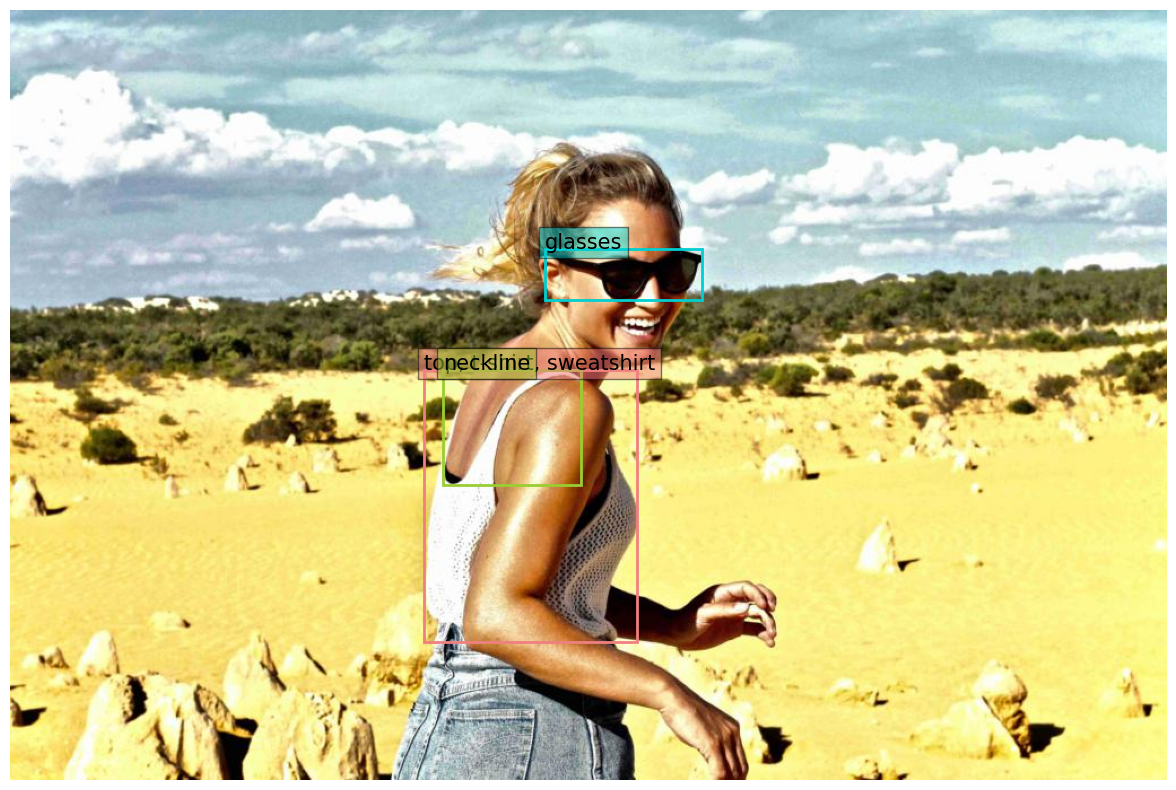

In [14]:
random_i = random.randint(0, train_dataset.num_rows)
print(f"Plotting random item {random_i}")
random_item = train_dataset[random_i]
plot_results(random_item['image'], random_item['objects']['bbox'], idx_to_text(random_item['objects']['category']))

### Preprocessing our dataset

In [15]:
from datasets import Dataset

def filter_invalid_bboxes(example):
    valid_bboxes = []
    valid_bbox_ids = []
    valid_categories = []
    valid_areas = []

    for i, bbox in enumerate(example['objects']['bbox']):
        x_min, y_min, x_max, y_max = bbox[:4]
        if x_min < x_max and y_min < y_max:
            valid_bboxes.append(bbox)
            valid_bbox_ids.append(example['objects']['bbox_id'][i])
            valid_categories.append(example['objects']['category'][i])
            valid_areas.append(example['objects']['area'][i])
        else:
            print(f"Image with invalid bbox: {example['image_id']} Invalid bbox detected and discarded: {bbox} - bbox_id: {example['objects']['bbox_id'][i]} - category: {example['objects']['category'][i]}")

    example['objects']['bbox'] = valid_bboxes
    example['objects']['bbox_id'] = valid_bbox_ids
    example['objects']['category'] = valid_categories
    example['objects']['area'] = valid_areas

    return example

train_dataset = train_dataset.map(filter_invalid_bboxes)
val_dataset = val_dataset.map(filter_invalid_bboxes)

Map:   0%|          | 0/45623 [00:00<?, ? examples/s]

Image with invalid bbox: 8396 Invalid bbox detected and discarded: [0.0, 0.0, 0.0, 0.0] - bbox_id: 139952 - category: 42
Image with invalid bbox: 19725 Invalid bbox detected and discarded: [0.0, 0.0, 0.0, 0.0] - bbox_id: 23298 - category: 42
Image with invalid bbox: 19725 Invalid bbox detected and discarded: [0.0, 0.0, 0.0, 0.0] - bbox_id: 23299 - category: 42
Image with invalid bbox: 21696 Invalid bbox detected and discarded: [0.0, 0.0, 0.0, 0.0] - bbox_id: 277148 - category: 42
Image with invalid bbox: 23055 Invalid bbox detected and discarded: [0.0, 0.0, 0.0, 0.0] - bbox_id: 287029 - category: 33
Image with invalid bbox: 23671 Invalid bbox detected and discarded: [0.0, 0.0, 0.0, 0.0] - bbox_id: 290142 - category: 42
Image with invalid bbox: 26549 Invalid bbox detected and discarded: [0.0, 0.0, 0.0, 0.0] - bbox_id: 311943 - category: 37
Image with invalid bbox: 26834 Invalid bbox detected and discarded: [0.0, 0.0, 0.0, 0.0] - bbox_id: 309141 - category: 37
Image with invalid bbox: 31

Map:   0%|          | 0/1158 [00:00<?, ? examples/s]

In [16]:
print(train_dataset)
print(val_dataset)

Dataset({
    features: ['image_id', 'image', 'width', 'height', 'objects'],
    num_rows: 45623
})
Dataset({
    features: ['image_id', 'image', 'width', 'height', 'objects'],
    num_rows: 1158
})


### Visualizing Class Occurrences

In [17]:
id_list = []
category_examples = {}

for example in train_dataset:
    id_list += example['objects']['bbox_id']
    
    # get the category ids
    category_ids = example['objects']['category']
    
    # map ids to text using your function
    category_labels = idx_to_text(category_ids)
    
    for label in category_labels:
        if label not in category_examples:
            category_examples[label] = 1
        else:
            category_examples[label] += 1

id_list.sort()


/tmp/ipykernel_31/2453834338.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(categories, rotation=90, ha='right')


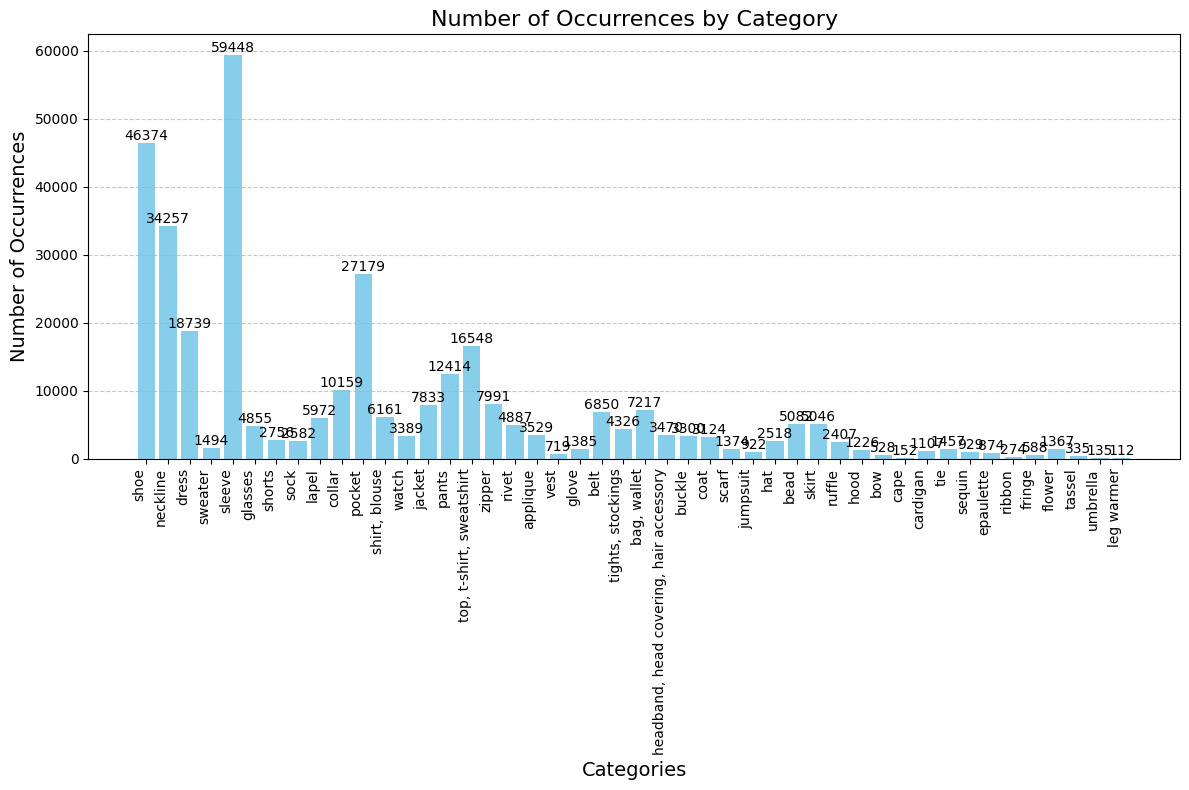

In [18]:
import matplotlib.pyplot as plt

categories = list(category_examples.keys())
values = list(category_examples.values())

fig, ax = plt.subplots(figsize=(12, 8))

bars = ax.bar(categories, values, color='skyblue')

ax.set_xlabel('Categories', fontsize=14)
ax.set_ylabel('Number of Occurrences', fontsize=14)
ax.set_title('Number of Occurrences by Category', fontsize=16)

ax.set_xticklabels(categories, rotation=90, ha='right')
ax.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2.0, height,
        f'{height}', ha='center', va='bottom', fontsize=10
    )

plt.tight_layout()
plt.show()

### Data Augmentation

In [28]:
import albumentations as A

train_transform = A.Compose(
    [
        A.LongestMaxSize(500),
        A.PadIfNeeded(500, 500, border_mode=0, value=(0, 0, 0)),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.HueSaturationValue(p=0.5),
        A.Rotate(limit=10, p=0.5),
        A.RandomScale(scale_limit=0.2, p=0.5),
        A.GaussianBlur(p=0.5),
        A.GaussNoise(p=0.5),
    ],
     bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category'])
)

val_transform = A.Compose(
    [
        A.LongestMaxSize(500),
        A.PadIfNeeded(500, 500, border_mode=0, value=(0, 0, 0)),
    ],
     bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category'])

)

/tmp/ipykernel_31/1840898228.py:6: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(500, 500, border_mode=0, value=(0, 0, 0)),
/tmp/ipykernel_31/1840898228.py:21: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(500, 500, border_mode=0, value=(0, 0, 0)),


In [20]:
# In order to use our images for the training, we're going to preprocess them, it is possible to use the YOLOs preprocessor.
feature_extractor = AutoFeatureExtractor.from_pretrained("hustvl/yolos-small", size=816, max_size=864)

preprocessor_config.json:   0%|          | 0.00/292 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.13k [00:00<?, ?B/s]

2025-04-27 14:10:40.170871: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745763040.471067      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745763040.546882      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/transformers/models/yolos/feature_extraction_yolos.py:38: FutureWarning: The class YolosFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use YolosImageProcessor instead.
  warnings.warn(
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [26]:
def transform(batch):
    inputs = {}
    image = batch['image']
    image = fix_channels(ToTensor()(image[0]))
    inputs['pixel_values'] = feature_extractor([image], return_tensors='pt')['pixel_values']
    labels = []
    bbox = [rescale_bboxes(batch['objects'][i]['bbox'], (batch['width'][i], batch['height'][i])) for i in range(len(batch['objects']))]
    bbox = [xyxy_to_xcycwh(torch.Tensor(bbox_i)) for bbox_i in bbox]
    labels.append({
        "boxes": bbox,
        "class_labels": [object['category'] for object in batch['objects']],
        "image_id": torch.Tensor([batch['image_id']]).int(),
        "area": [object['area'] for object in batch['objects']],
        "iscrowd": torch.Tensor([0 for _ in batch['objects']]).int(),
        "orig_size": torch.Tensor([(batch['width'], batch['height'])]).int(),
        "size": torch.Tensor([inputs['pixel_values'].shape[1:]])[0].int(),
    })
    inputs['labels'] = labels
    return inputs



# Separate wrappers for training and validation
def transform_train(batch):
    return transform(batch)

def transform_val(batch):
    return transform(batch)

In [27]:
prepared_train = train_dataset.with_transform(transform_train)
prepared_val = val_dataset.with_transform(transform_val)

### Visualizing Augmented Data

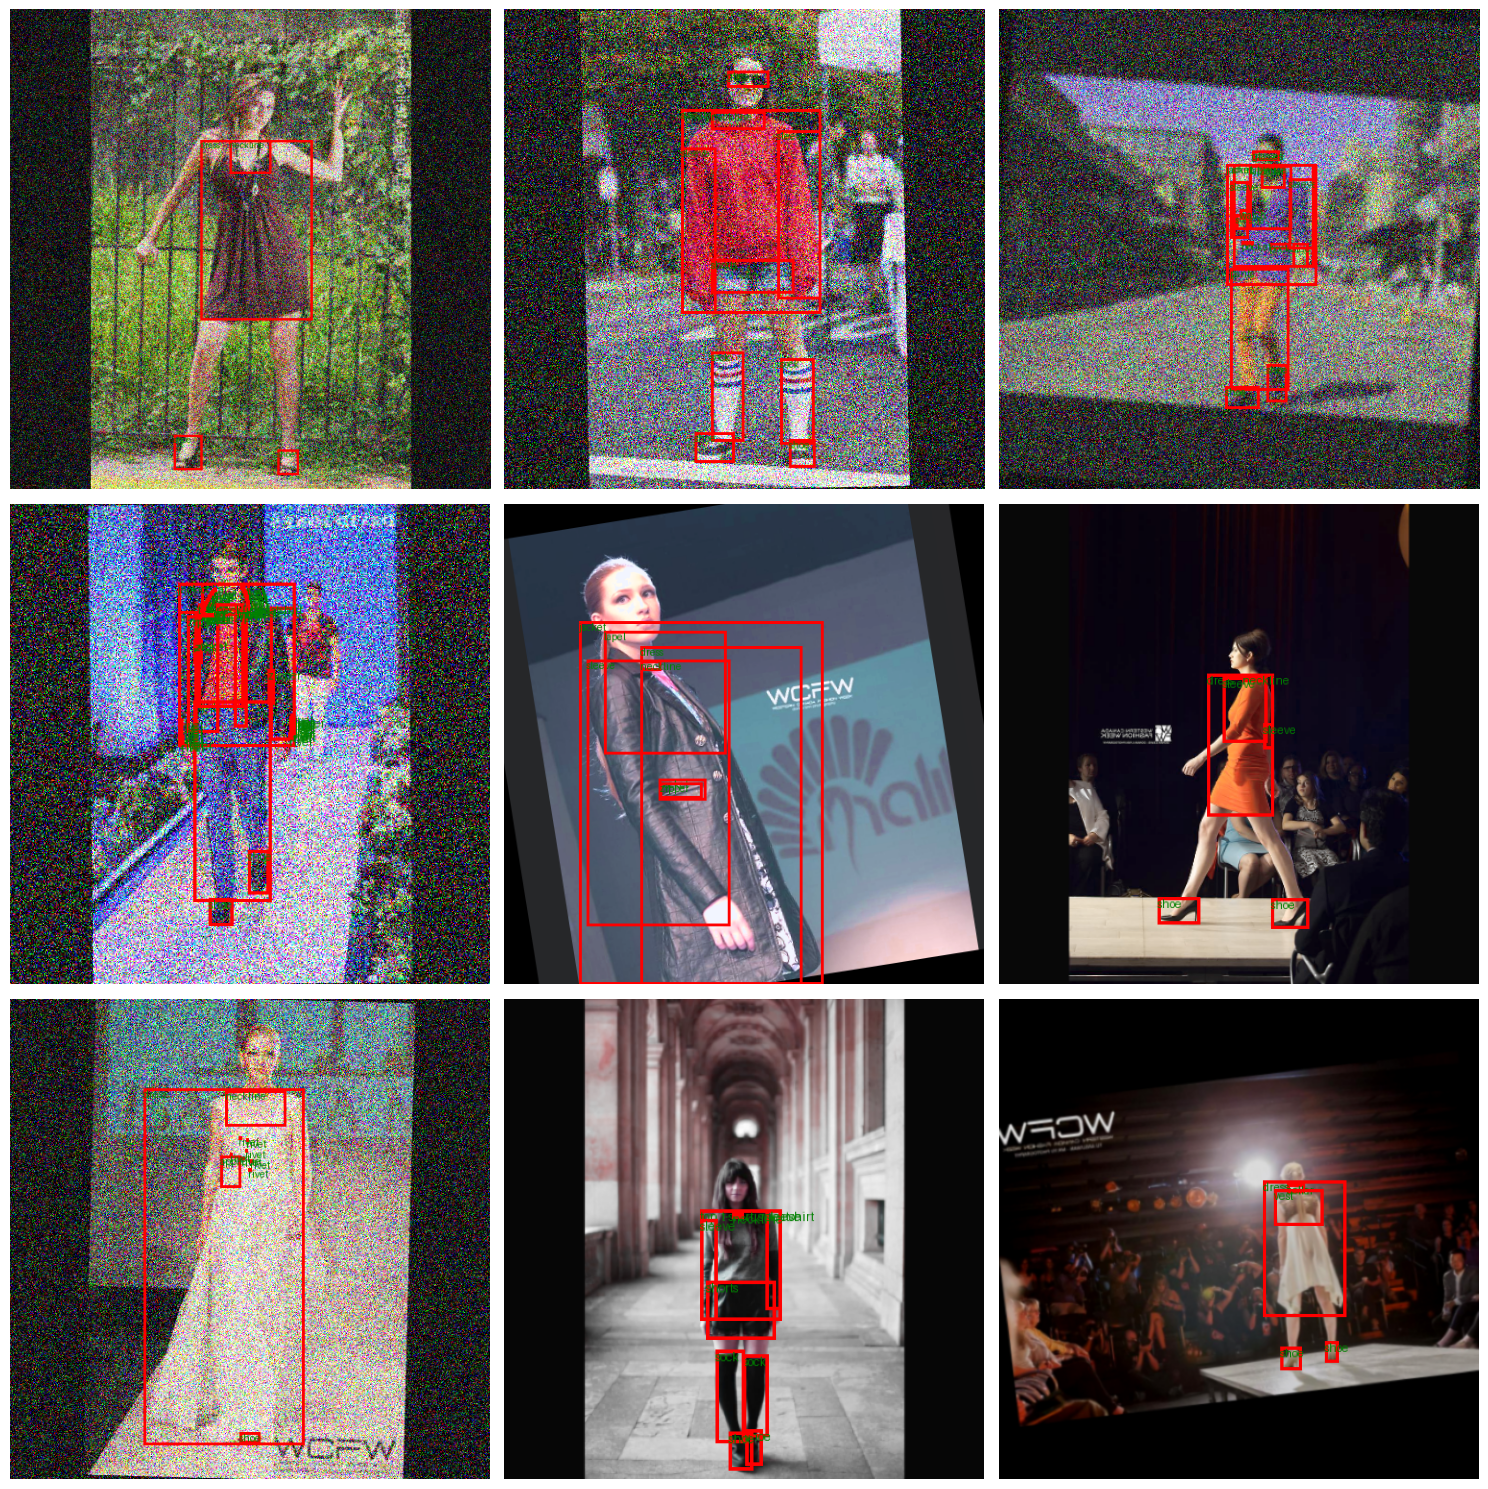

In [29]:
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

def draw_augmented_image_from_idx(dataset, idx, transform=None):
    sample = dataset[idx]
    image = sample["image"]
    annotations = sample["objects"]

    width, height = sample["width"], sample["height"]

    # Convert image to RGB and NumPy array
    image = np.array(image.convert("RGB"))[:, :, ::-1]  # Convert PIL to OpenCV (BGR)

    bboxes = annotations["bbox"]
    categories = annotations["category"]

    if transform:
        augmented = transform(image=image, bboxes=bboxes, category=categories)
        image = augmented["image"]
        bboxes = augmented["bboxes"]
        categories = augmented["category"]

        height, width = image.shape[:2]  # In case size changes after transform

    # Convert back to PIL Image for drawing
    image = Image.fromarray(image[:, :, ::-1])  # Convert back to RGB
    draw = ImageDraw.Draw(image)

    # 🔥 Use idx_to_text to convert category IDs into labels
    labels = idx_to_text(categories)

    for i in range(len(bboxes)):
        box = bboxes[i]
        x1, y1, x2, y2 = tuple(box)

        # Normalize coordinates if necessary
        if max(box) <= 1.0:
            x1, y1 = int(x1 * width), int(y1 * height)
            x2, y2 = int(x2 * width), int(y2 * height)
        else:
            x1, y1 = int(x1), int(y1)
            x2, y2 = int(x2), int(y2)

        draw.rectangle((x1, y1, x2, y2), outline="red", width=3)
        draw.text((x1, y1), labels[i], fill="green")  # ⬅️ Using label from idx_to_text

    return image

def plot_augmented_images(dataset, indices, transform=None):
    """
    Plot images and their annotations with optional augmentation.
    """
    num_cols = 3
    num_rows = (len(indices) + num_cols - 1) // num_cols  # Auto adjust

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

    if num_rows == 1:
        axes = np.expand_dims(axes, axis=0)

    for i, idx in enumerate(indices):
        row = i // num_cols
        col = i % num_cols

        # Draw augmented image
        image = draw_augmented_image_from_idx(dataset, idx, transform=transform)

        axes[row, col].imshow(image)
        axes[row, col].axis("off")

    # Hide any unused subplots
    total = num_rows * num_cols
    for j in range(len(indices), total):
        row = j // num_cols
        col = j % num_cols
        axes[row, col].axis("off")

    plt.tight_layout()
    plt.show()

# Example usage
plot_augmented_images(train_dataset, range(9), transform=train_transform)


In [30]:
def collate_fn(batch):
    collated = {}
    collated["pixel_values"] = feature_extractor.pad([item['pixel_values'] for item in batch], return_tensors="pt")['pixel_values']
    collated["labels"] = []
    for item in batch:
        item['labels']['boxes'] = torch.stack(item['labels']['boxes'])[0]
        item['labels']['area'] = torch.Tensor(item['labels']['area'])
        item['labels']['class_labels'] = torch.Tensor(item['labels']['class_labels'])[0]
        item['labels']['class_labels'] = item['labels']['class_labels'].type(torch.LongTensor)
        collated["labels"].append(item['labels'])
    return collated

In [31]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))

Number of training examples: 45623
Number of validation examples: 1158


In [32]:
BATCH_SIZE = 1
train_dataloader = DataLoader(prepared_train, collate_fn=collate_fn, batch_size=BATCH_SIZE)
val_dataloader = DataLoader(prepared_val, collate_fn=collate_fn, batch_size=BATCH_SIZE)

In [33]:
item = next(iter(train_dataloader))

In [34]:
item

{'pixel_values': tensor([[[[-0.2856, -0.3541, -0.5767,  ...,  0.1254,  0.2282,  0.2282],
           [-0.1143, -0.2684, -0.3541,  ...,  0.2111,  0.2967,  0.2282],
           [-0.0287, -0.3027, -0.3369,  ..., -0.1657, -0.0629, -0.1143],
           ...,
           [ 1.8893,  1.9064,  1.9407,  ...,  2.2147,  2.2318,  2.2318],
           [ 1.9578,  1.9920,  2.0263,  ...,  2.1633,  2.2318,  2.2489],
           [ 2.0092,  2.0434,  2.1119,  ...,  2.0434,  2.1975,  2.2489]],
 
          [[-0.1625, -0.2325, -0.4601,  ...,  0.2752,  0.3803,  0.3803],
           [ 0.0126, -0.1450, -0.2325,  ...,  0.3627,  0.4503,  0.3803],
           [ 0.0826, -0.1800, -0.2325,  ..., -0.0224,  0.0826,  0.0301],
           ...,
           [ 1.5882,  1.6057,  1.6232,  ...,  2.2185,  2.2360,  2.2360],
           [ 1.6057,  1.6232,  1.6758,  ...,  2.1310,  2.2185,  2.2185],
           [ 1.6057,  1.6583,  1.7283,  ...,  2.0084,  2.1660,  2.2360]],
 
          [[-0.4275, -0.4798, -0.6890,  ...,  0.2173,  0.3219,  0.3219

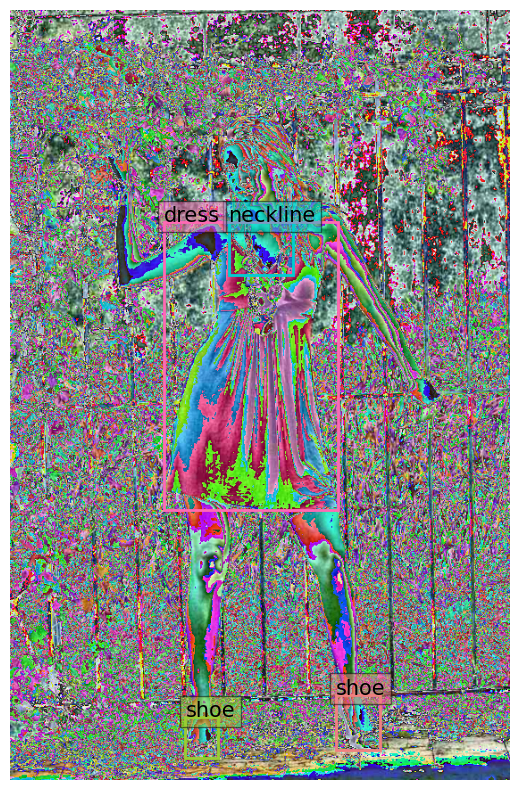

In [35]:
random_i = random.randint(0, BATCH_SIZE-1)
random_i = 0
pil_image = transforms.ToPILImage()(item['pixel_values'][random_i])
class_labels = item['labels'][random_i]['class_labels']
size = pil_image.size
boxes = rescale_bboxes(cxcywh_to_xyxy(item['labels'][random_i]['boxes']), size, down=False)
plot_results(pil_image, boxes, idx_to_text(class_labels.tolist()))

In [36]:
class Detr(pl.LightningModule):

     def __init__(self, lr, weight_decay):
         super().__init__()
         self.model = AutoModelForObjectDetection.from_pretrained("hustvl/yolos-small",
                                                                  num_labels=cats.num_classes,
                                                             ignore_mismatched_sizes=True)
         self.lr = lr
         self.weight_decay = weight_decay

     def forward(self, pixel_values):
       outputs = self.model(pixel_values=pixel_values)
       return outputs

     def common_step(self, batch, batch_idx):
       pixel_values = batch["pixel_values"]
       labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

       outputs = self.model(pixel_values=pixel_values, labels=labels)

       loss = outputs.loss
       loss_dict = outputs.loss_dict

       return loss, loss_dict

     def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
          self.log("train_" + k, v.item())

        return loss

     def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("validation_loss", loss)
        for k,v in loss_dict.items():
          self.log("validation_" + k, v.item())

        return loss

     def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr,
                                  weight_decay=self.weight_decay)

        return optimizer

     def train_dataloader(self):
        return train_dataloader

     def val_dataloader(self):
        return val_dataloader

Here we define the model, and verify the outputs.

In [37]:
model = Detr(lr=2.5e-5, weight_decay=1e-4)

model.safetensors:   0%|          | 0.00/123M [00:00<?, ?B/s]

Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-small and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([47]) in the model instantiated
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 384]) in the checkpoint and torch.Size([47, 384]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
model

Detr(
  (model): YolosForObjectDetection(
    (vit): YolosModel(
      (embeddings): YolosEmbeddings(
        (patch_embeddings): YolosPatchEmbeddings(
          (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (interpolation): InterpolateInitialPositionEmbeddings()
      )
      (encoder): YolosEncoder(
        (layer): ModuleList(
          (0-11): 12 x YolosLayer(
            (attention): YolosAttention(
              (attention): YolosSelfAttention(
                (query): Linear(in_features=384, out_features=384, bias=True)
                (key): Linear(in_features=384, out_features=384, bias=True)
                (value): Linear(in_features=384, out_features=384, bias=True)
              )
              (output): YolosSelfOutput(
                (dense): Linear(in_features=384, out_features=384, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
            )
  

In [ ]:
trainer = Trainer(max_epochs=1, accelerator="gpu", devices=1)
trainer.fit(model)

INFO: Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: 
  | Name  | Type                    | Params | Mode
---------------------------------------------------------
0 | model | YolosForObjectDetection | 30.7 M | eval
---------------------------------------------------------
30.7 M    Trainable params
0         Non-trainable params
30.7 M    Total params
122.670   Total estimated model params size (MB)
0         Modules in train mode
225       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

In [ ]:
model

In [ ]:
# model.model.push_to_hub("yolos-fashionpedia")

In [ ]:
# Save entire LightningModule (includes YOLOS model + config)
torch.save(model.state_dict(), "detr_lightning_weights.pth")


In [ ]:
model.model.save_pretrained("saved_yolos_model")


That's it!

In [ ]:
model = Detr(lr=1e-4, weight_decay=1e-4)
model.load_state_dict(torch.load("detr_lightning_weights.pth"))
model.eval()


In [ ]:
from transformers import AutoModelForObjectDetection

model = AutoModelForObjectDetection.from_pretrained("saved_yolos_model")
model.eval()


In [ ]:
import torch
dummy_input = torch.randn(1, 3, 640, 640)  # example input shape
torch.onnx.export(model.model,               # Hugging Face model
                  dummy_input,
                  "yolos_model.onnx",
                  opset_version=11,
                  input_names=["pixel_values"],
                  output_names=["output"])
